# Персонализация предложений для удержания клиентов интернет-магазина методом машинного обучения


Разработка системы персонализированных предложений для интернет-магазина «В один клик», основываясь на ML. **Цель - построение модели:**

- Классификационной модели для предсказания снижения покупательской активности клиентов
- Сегментация клиентов на основе результатов моделирования и прибыльности
- Разработка персонализированных предложений для каждого сегмента

Это позволит принимать объективные решения по удержанию клиентов, снизив отток и увеличив прибыльность.


**Задачи:**

- Провести разведывательный анализ данных о клиентах
- Выполнить предобработку четырёх наборов данных
- Исследовать взаимосвязи признаков с целевой меткой
- Построить четыре модели классификации и выбрать лучшую по метрикам F1-score, ROC-AUC
- Проанализировать важность признаков с помощью SHAP
- Выполнить сегментацию покупателей на основе модели и прибыльности
- Сформировать рекомендации бизнесу: как работать с каждым сегментом


**Описание входных данных:**

`market_file.csv`

Содержит основные данные о клиентах интернет-магазина. Включает:

- Признаки коммуникации с клиентом (маркетинговые активности, согласие на рассылки)
- Признаки продуктового поведения (категории товаров, акционные покупки)
- Признаки поведения на сайте (количество страниц, просмотры категорий)
- Целевой признак: Покупательская активность

`market_money.csv`

Данные о выручке по периодам для каждого клиента

`market_time.csv`

Данные о времени, проведенном на сайте по периодам

`money.csv`

Данные о прибыльности каждого клиента за последние 3 месяца


**Методы:**

- Предобработка и очистка данных (pandas, numpy)
- Визуальный анализ (matplotlib, seaborn)
- Моделирование (sklearn: KNeighborsClassifier, DecisionTreeClassifier, LogisticRegression, SVC)
- Пайплайны предобработки (ColumnTransformer, Pipeline)
- Анализ важности признаков (SHAP)
- Оценка качества моделей (F1-score, ROC-AUC, accuracy, precision, recall)


**Целевой признак:**

- Покупательская активность — целевой признак задачи классификации («снизилась» или «прежний уровень»)


**Критерии успешности:**

- F1-score >= 0.7 для лучшей модели
- ROC-AUC >= 0.8 для оценки качества классификации
- Выделение сегментов клиентов с персонализированными предложениями


In [1]:
# Установка необходимых библиотек
import subprocess
import sys

def install_package(package):
    try:
        __import__(package)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Устанавливаем необходимые библиотеки
packages = ['statsmodels', 'shap']
for package in packages:
    install_package(package)

## Загрузка данных


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [3]:
# Приведение названий столбцов к змеиному стилю
import re

def to_snake_case(column_name):
    column_name = re.sub(r'[^\w\s]', '_', column_name)
    column_name = re.sub(r'\s+', '_', column_name)
    column_name = column_name.lower()
    column_name = re.sub(r'_+', '_', column_name)
    column_name = column_name.strip('_')
    return column_name

# Загрузка данных с обработкой ошибок
try:
    market_file = pd.read_csv('market_file.csv', encoding='utf-8')
    market_money = pd.read_csv('market_money.csv', encoding='utf-8')
    market_time = pd.read_csv('market_time.csv', encoding='utf-8')
    money = pd.read_csv('money.csv', sep=';', decimal=',', encoding='utf-8')
except FileNotFoundError:
    try:
        market_file = pd.read_csv('/datasets/market_file.csv', encoding='utf-8')
        market_money = pd.read_csv('/datasets/market_money.csv', encoding='utf-8')
        market_time = pd.read_csv('/datasets/market_time.csv', encoding='utf-8')
        money = pd.read_csv('/datasets/money.csv', sep=';', decimal=',', encoding='utf-8')
    except FileNotFoundError:
        raise

market_file.columns = [to_snake_case(col) for col in market_file.columns]
market_money.columns = [to_snake_case(col) for col in market_money.columns]
market_time.columns = [to_snake_case(col) for col in market_time.columns]
money.columns = [to_snake_case(col) for col in money.columns]

In [4]:
print(f"money.csv размер: {money.shape}")
print(f"money.csv столбцы: {money.columns.tolist()}")

money.csv размер: (1300, 2)
money.csv столбцы: ['id', 'прибыль']


In [5]:
print(money.head())

       id  прибыль
0  215348     0.98
1  215349     4.16
2  215350     3.13
3  215351     4.87
4  215352     4.21


In [6]:
print("market_file:", market_file.columns.tolist())

market_file: ['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать', 'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'популярная_категория', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит']


In [7]:
print("market_money:", market_money.columns.tolist())

market_money: ['id', 'период', 'выручка']


In [8]:
print("market_time:", market_time.columns.tolist())

market_time: ['id', 'период', 'минут']


In [9]:
print("money:", money.columns.tolist())

money: ['id', 'прибыль']


In [10]:
print(f"market_file: {market_file.shape}")

market_file: (1300, 13)


In [11]:
print(f"market_money: {market_money.shape}")

market_money: (3900, 3)


In [12]:
print(f"market_time: {market_time.shape}")

market_time: (2600, 3)


In [13]:
print(f"money: {money.shape}")

money: (1300, 2)


Столбцы market_file

In [14]:
print(market_file.columns.tolist())

['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать', 'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'популярная_категория', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит']


Распределение целевого признака

In [15]:
print(market_file['покупательская_активность'].value_counts())

покупательская_активность
Прежний уровень    802
Снизилась          498
Name: count, dtype: int64


Первые 5 строк

In [16]:
display(market_file.head())

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


**Выводы после загрузки данных:**

1. **Размеры датасетов:**
   - `market_file`: 1300 клиентов × 13 признаков
   - `market_money`: 3900 записей × 3 столбца (выручка по периодам)
   - `market_time`: 2600 записей × 3 столбца (время на сайте)
   - `money`: 1300 клиентов × 2 столбца (прибыльность)

2. **Целевой признак:**
   - 61.7% клиентов: прежний уровень активности (802)
   - 38.3% клиентов: снижение активности (498)
   - Баланс классов: 0.62 (умеренный дисбаланс)

3. **Качество данных:**
   - Пропущенные значения: отсутствуют
   - Названия столбцов приведены к змеиному стилю
   - Данные готовы к предобработке

## Предобработка данных


In [17]:
# Поиск скрытых дубликатов
print(f'Дубликаты по ID в market_file: {market_file["id"].duplicated().sum()}')
print(f'Полные дубликаты в market_file: {market_file.duplicated().sum()}')

# Удаляем дубликаты
market_file = market_file.drop_duplicates()
market_money = market_money.drop_duplicates()
market_time = market_time.drop_duplicates()
money = money.drop_duplicates()

Дубликаты по ID в market_file: 0
Полные дубликаты в market_file: 0


In [18]:
# Фильтрация неактивных клиентов

# Находим клиентов с покупками в последние месяцы
# (у кого есть ненулевая выручка хотя бы в одном из трех последних месяцев)
if 'период' in market_money.columns:
    latest_periods = sorted(market_money['период'].unique())[-3:]
    active_clients = market_money[
        (market_money['период'].isin(latest_periods)) & 
        (market_money['выручка'] > 0)
    ]['id'].unique()
    
    print(f'Активных клиентов: {len(active_clients)} из {len(market_file)}')
    
    print(f'market_file: {market_file.columns.tolist()}')
    print(f'market_money: {market_money.columns.tolist()}')
    print(f'market_time: {market_time.columns.tolist()}')
    print(f'money: {money.columns.tolist()}')
    
    # Оставляем только активных клиентов
    market_file = market_file[market_file['id'].isin(active_clients)]
    market_money = market_money[market_money['id'].isin(active_clients)]
    market_time = market_time[market_time['id'].isin(active_clients)]
    
    if 'id' in money.columns:
        money = money[money['id'].isin(active_clients)]
    else:
        id_col = None
        for col in money.columns:
            if 'id' in col.lower():
                id_col = col
                break
        
        if id_col:
            print(f'Используем столбец {id_col} вместо id')
            money = money[money[id_col].isin(active_clients)]
        else:
            print('Столбец с ID не найден в таблице money')
    
    print(f'После фильтрации: {market_file.shape[0]} клиентов')
else:
    print('Столбец \'период\' не найден в market_money')

Активных клиентов: 1300 из 1300
market_file: ['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать', 'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'популярная_категория', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит']
market_money: ['id', 'период', 'выручка']
market_time: ['id', 'период', 'минут']
money: ['id', 'прибыль']
После фильтрации: 1300 клиентов


In [19]:
# Преобразование данных о выручке в формат "один клиент - одна строка"
revenue_pivot = market_money.pivot(index='id', columns='период', values='выручка').reset_index()
revenue_pivot.columns = ['id'] + [f'Выручка_{col}' for col in revenue_pivot.columns[1:]]

# Преобразование данных о времени в формат "один клиент - одна строка"
time_pivot = market_time.pivot(index='id', columns='период', values='минут').reset_index()
time_pivot.columns = ['id'] + [f'Время_{col}' for col in time_pivot.columns[1:]]

# Объединение все таблицы
df_combined = market_file.copy()
df_combined = df_combined.merge(revenue_pivot, on='id', how='left')
df_combined = df_combined.merge(time_pivot, on='id', how='left')

# Проверяем названия столбцов в таблице money перед объединением
print('Названия столбцов в money:', money.columns.tolist())

# Находим правильное название столбца с ID в таблице money
money_id_col = None
for col in money.columns:
    if 'id' in col.lower():
        money_id_col = col
        break

if money_id_col:
    print(f'Используем столбец {money_id_col} для объединения с таблицей money')
    money_renamed = money.rename(columns={money_id_col: 'id'})
    df_combined = df_combined.merge(money_renamed, on='id', how='left')
else:
    print('Столбец с ID не найден в таблице money')
    print('Объединяем без таблицы money')

Названия столбцов в money: ['id', 'прибыль']
Используем столбец id для объединения с таблицей money


In [20]:
# Эта функция будет использоваться после получения предсказаний модели
# Пока что просто показываем, что она будет здесь

def create_segment(row):
    prob = row['predicted_probability']
    profit = row['прибыль']
    
    if prob >= prob_high and profit >= profit_high:
        return 'Высокий риск, высокая прибыль'
    elif prob >= prob_high and profit < profit_high:
        return 'Высокий риск, низкая прибыль'
    elif prob < prob_high and profit >= profit_high:
        return 'Низкий риск, высокая прибыль'
    else:
        return 'Низкий риск, низкая прибыль'

In [21]:
print(f"Размер объединенной таблицы: {df_combined.shape}")
print(f"Пропущенных значений: {df_combined.isnull().sum().sum()}")

Размер объединенной таблицы: (1300, 19)
Пропущенных значений: 0


## Исследовательский анализ данных


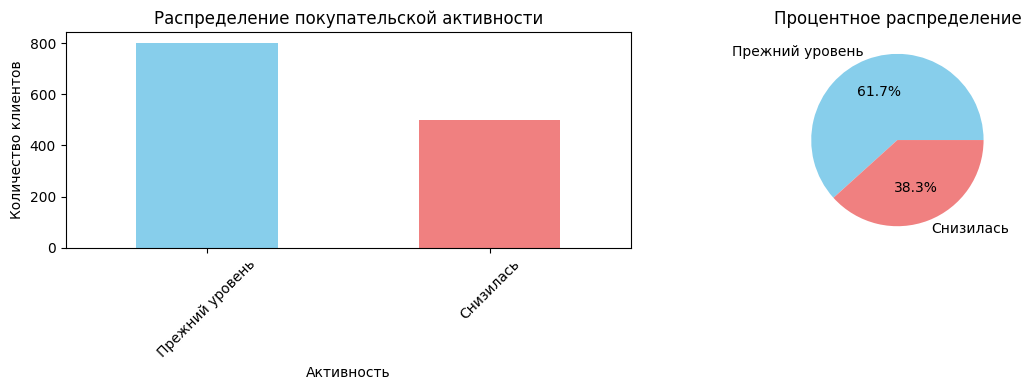

Найдено 14 числовых признаков


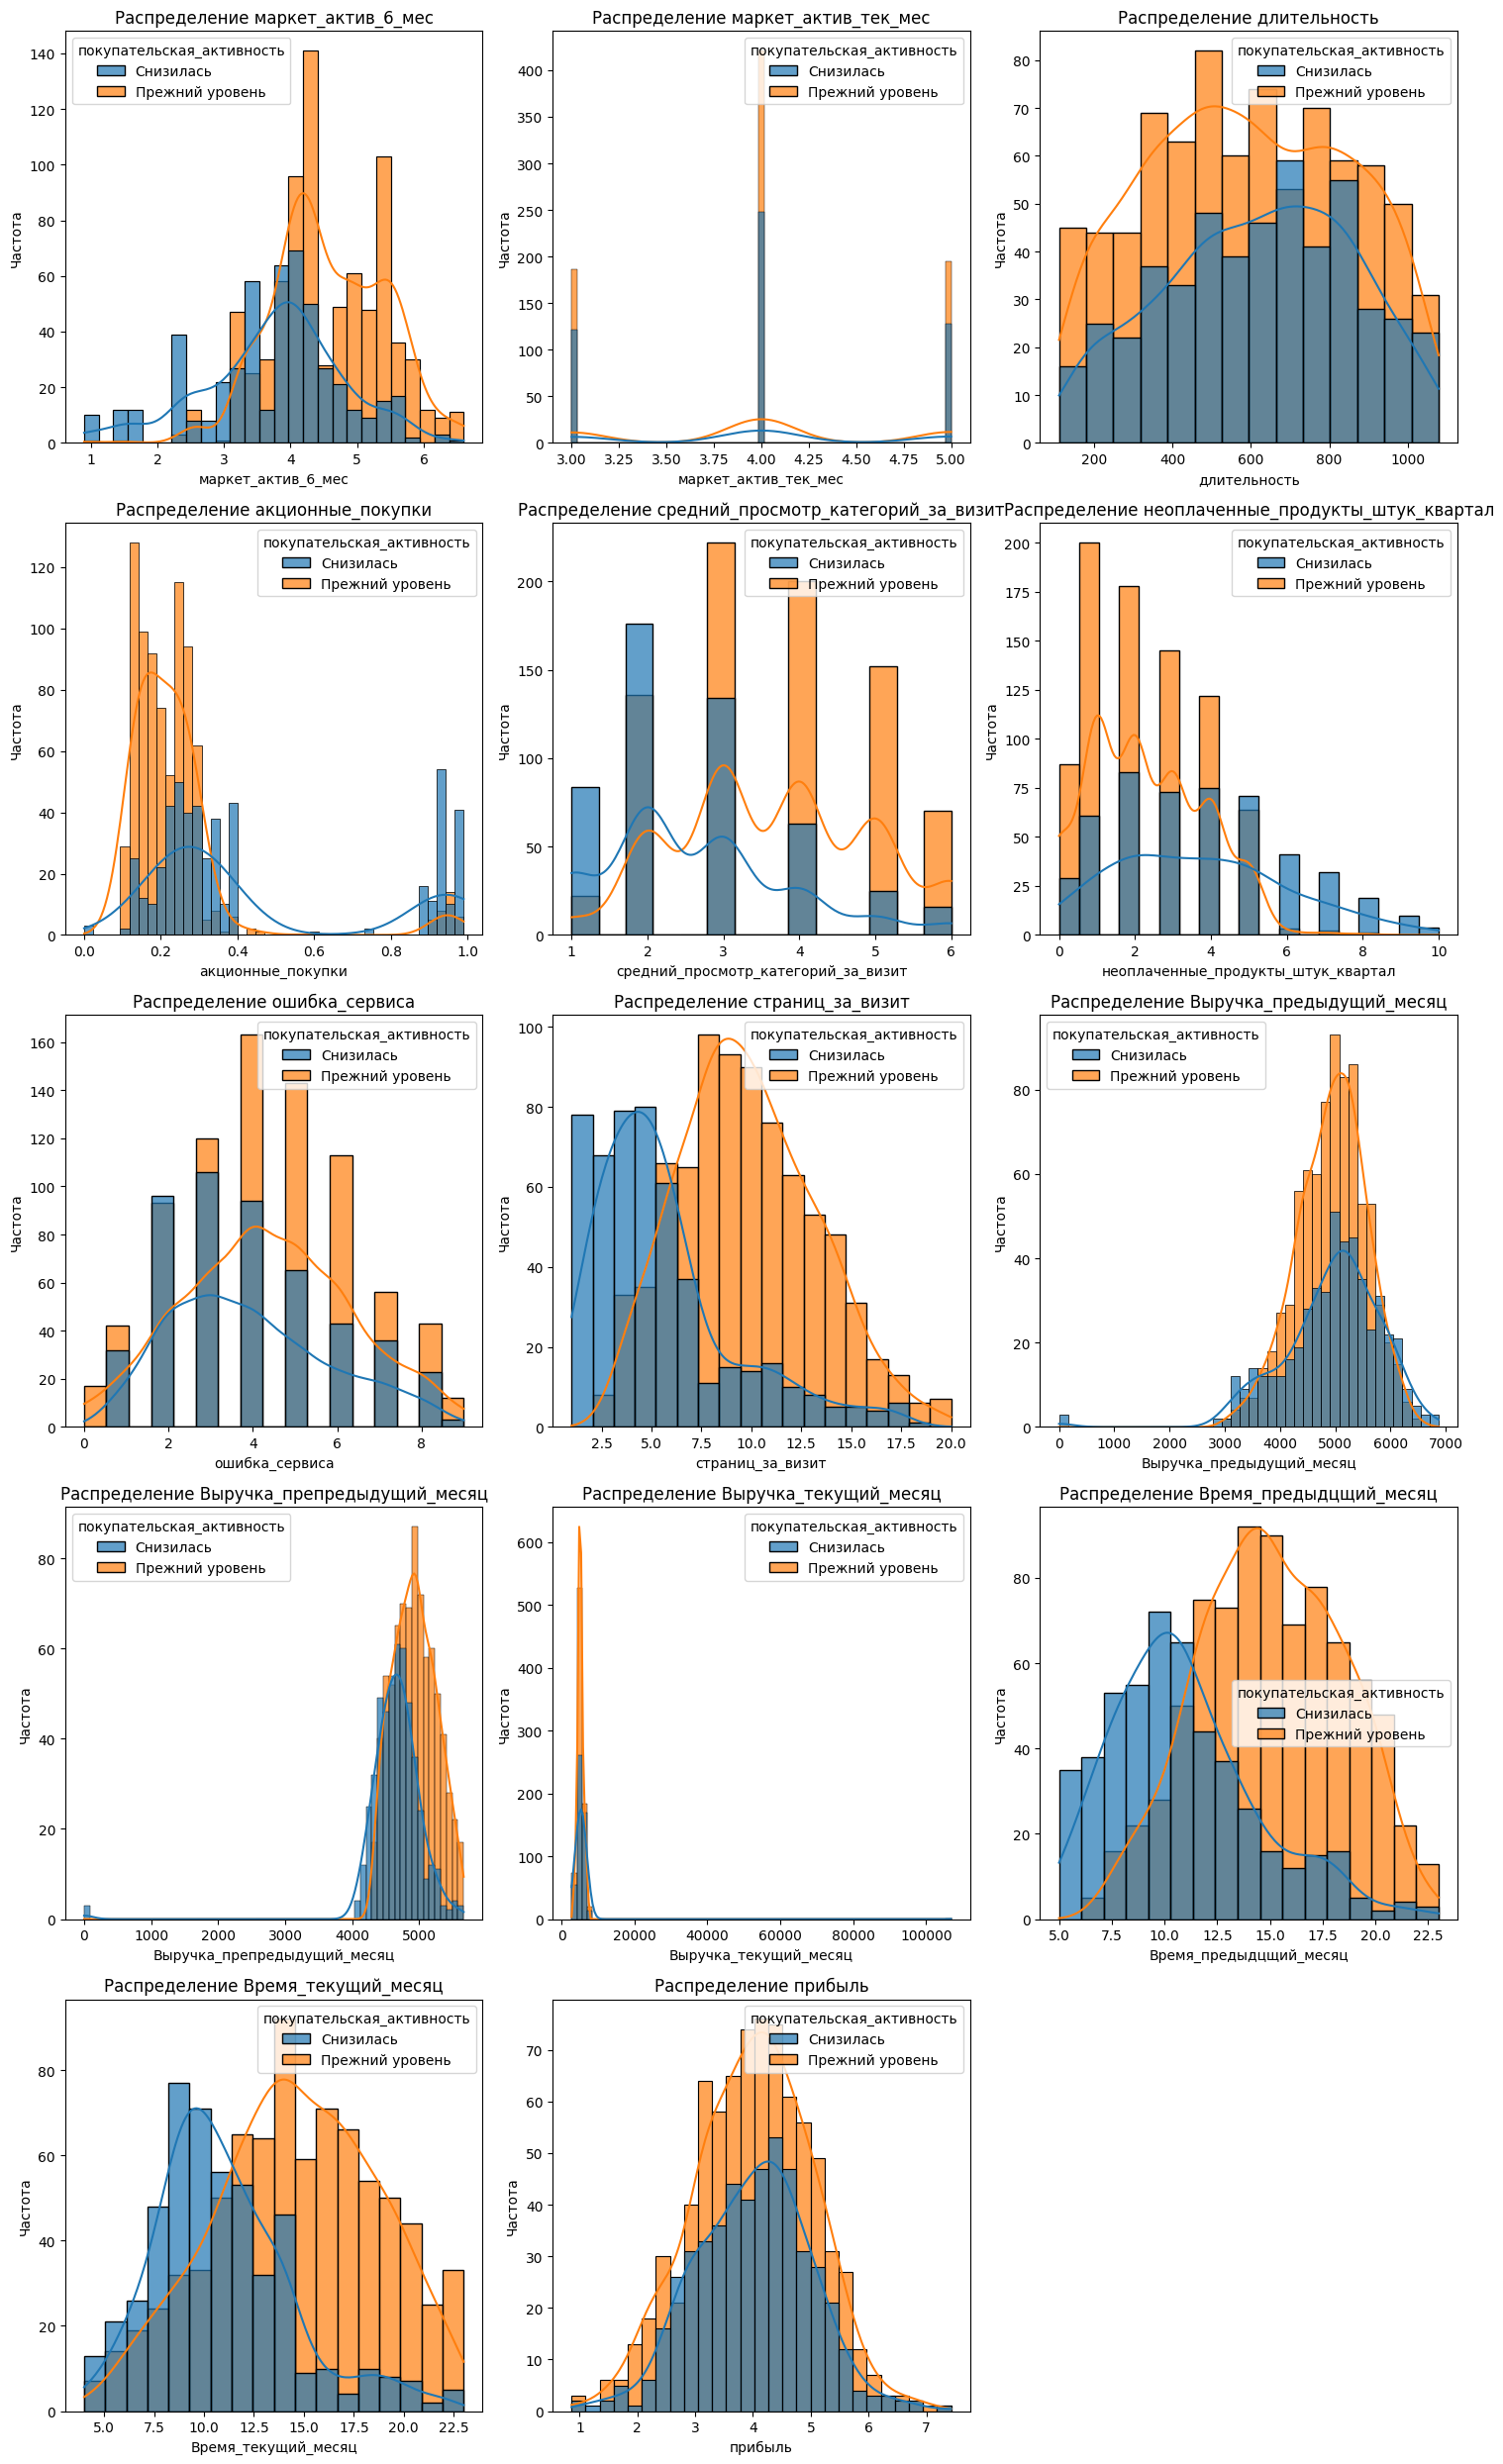

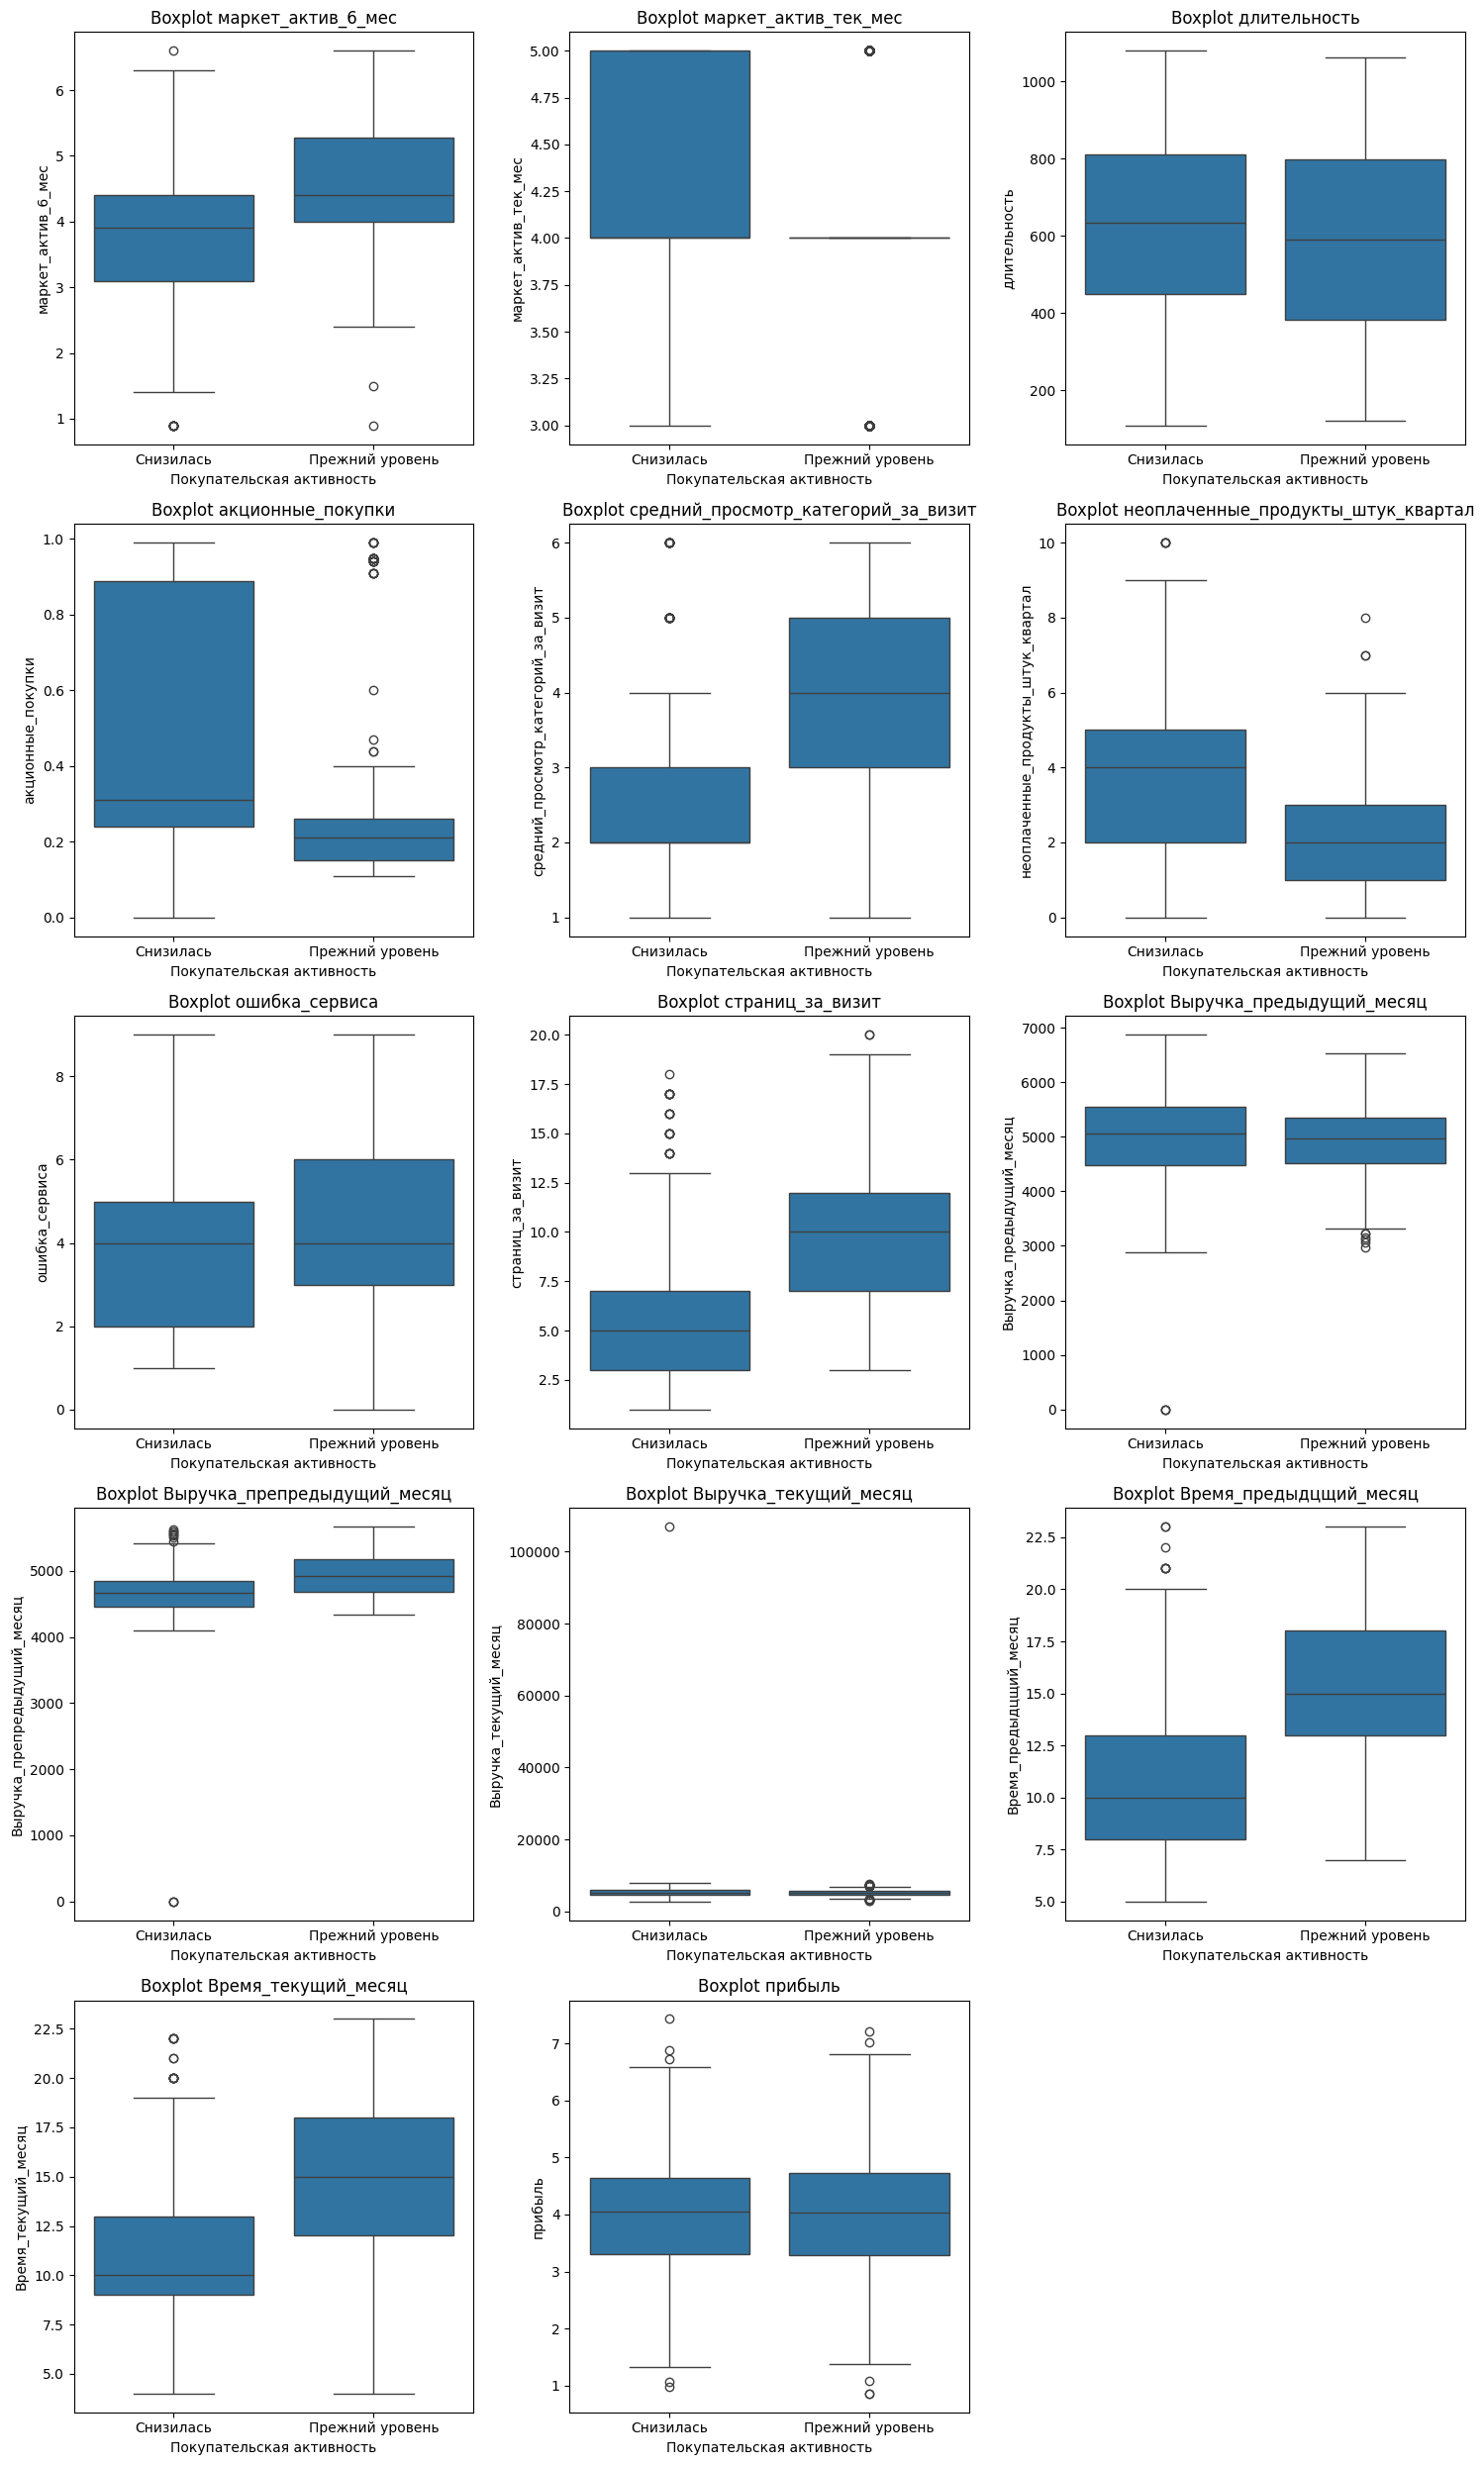

In [22]:
# Анализ целевого признака
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
df_combined['покупательская_активность'].value_counts().plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Распределение покупательской активности')
plt.xlabel('Активность')
plt.ylabel('Количество клиентов')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
df_combined['покупательская_активность'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])
plt.title('Процентное распределение')
plt.ylabel('')

plt.tight_layout()
plt.show()

# Графики для всех числовых признаков
numeric_features = df_combined.select_dtypes(include=[np.number]).columns.tolist()
numeric_features = [col for col in numeric_features if col not in ['id']]

print(f"Найдено {len(numeric_features)} числовых признаков")

n_features = len(numeric_features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten() if n_rows > 1 else [axes] if n_rows == 1 else axes

for i, feature in enumerate(numeric_features):
    if i < len(axes):
        sns.histplot(data=df_combined, x=feature, hue='покупательская_активность', 
                    kde=True, ax=axes[i], alpha=0.7)
        axes[i].set_title(f'Распределение {feature}')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Частота')

for i in range(len(numeric_features), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten() if n_rows > 1 else [axes] if n_rows == 1 else axes

for i, feature in enumerate(numeric_features):
    if i < len(axes):
        sns.boxplot(data=df_combined, x='покупательская_активность', y=feature, ax=axes[i])
        axes[i].set_title(f'Boxplot {feature}')
        axes[i].set_xlabel('Покупательская активность')
        axes[i].set_ylabel(feature)

for i in range(len(numeric_features), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

Дисбаланс классов 61.7% vs 38.3% требует учета при моделировании. Выбросы присутствуют в большинстве признаков, особенно в выручке и времени. Клиенты с "снизилась" активностью имеют статистически значимые отличия в поведенческих метриках. Большинство признаков не имеют нормального распределения, поэтому использование Спирмена корректно

Статистика по числовым признакам

In [23]:
numeric_cols = df_combined.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in ['id']]
display(df_combined[numeric_cols].describe())

,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,Время_предыдцщий_месяц,Время_текущий_месяц,прибыль
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000
mean,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923,4936.920385,4825.206923,5314.960846,13.467692,13.204615,3.996631
std,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126,739.597997,405.979663,2939.708156,3.932029,4.220589,1.013722
min,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000,0.000000,0.000000,2758.700000,5.000000,4.000000,0.860000
25%,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000,4496.750000,4583.000000,4706.050000,11.000000,10.000000,3.300000
50%,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000,5005.000000,4809.000000,5179.950000,13.000000,13.000000,4.045000
75%,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000,5405.625000,5053.500000,5761.725000,17.000000,16.000000,4.670000
max,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000,6869.500000,5663.000000,106862.200000,23.000000,23.000000,7.430000


- Анализ 1300 клиентов показал: 61.7% сохранили активность, 38.3% снизили
- Маркетинг упал с 4.25 до 4.01
- Клиенты просматривают 8 страниц за 13 минут, но только 0.32 акционных покупок
- Проблемы: ошибки сервиса (4.2 / 10), неоплаченные товары (2.8)
- Выручка выросла на 10% (4825 - 5315), прибыль 4.0 +- 1.0
- Главные факторы оттока: страницы за визит (0.48), просмотр категорий (0.40), время прошлый месяц (0.35)
- Приоритетный сегмент: 122 клиента (9.4%) с высокой прибылью и риском оттока 87.5% - требуют срочных мер удержания

## Корреляционный анализ


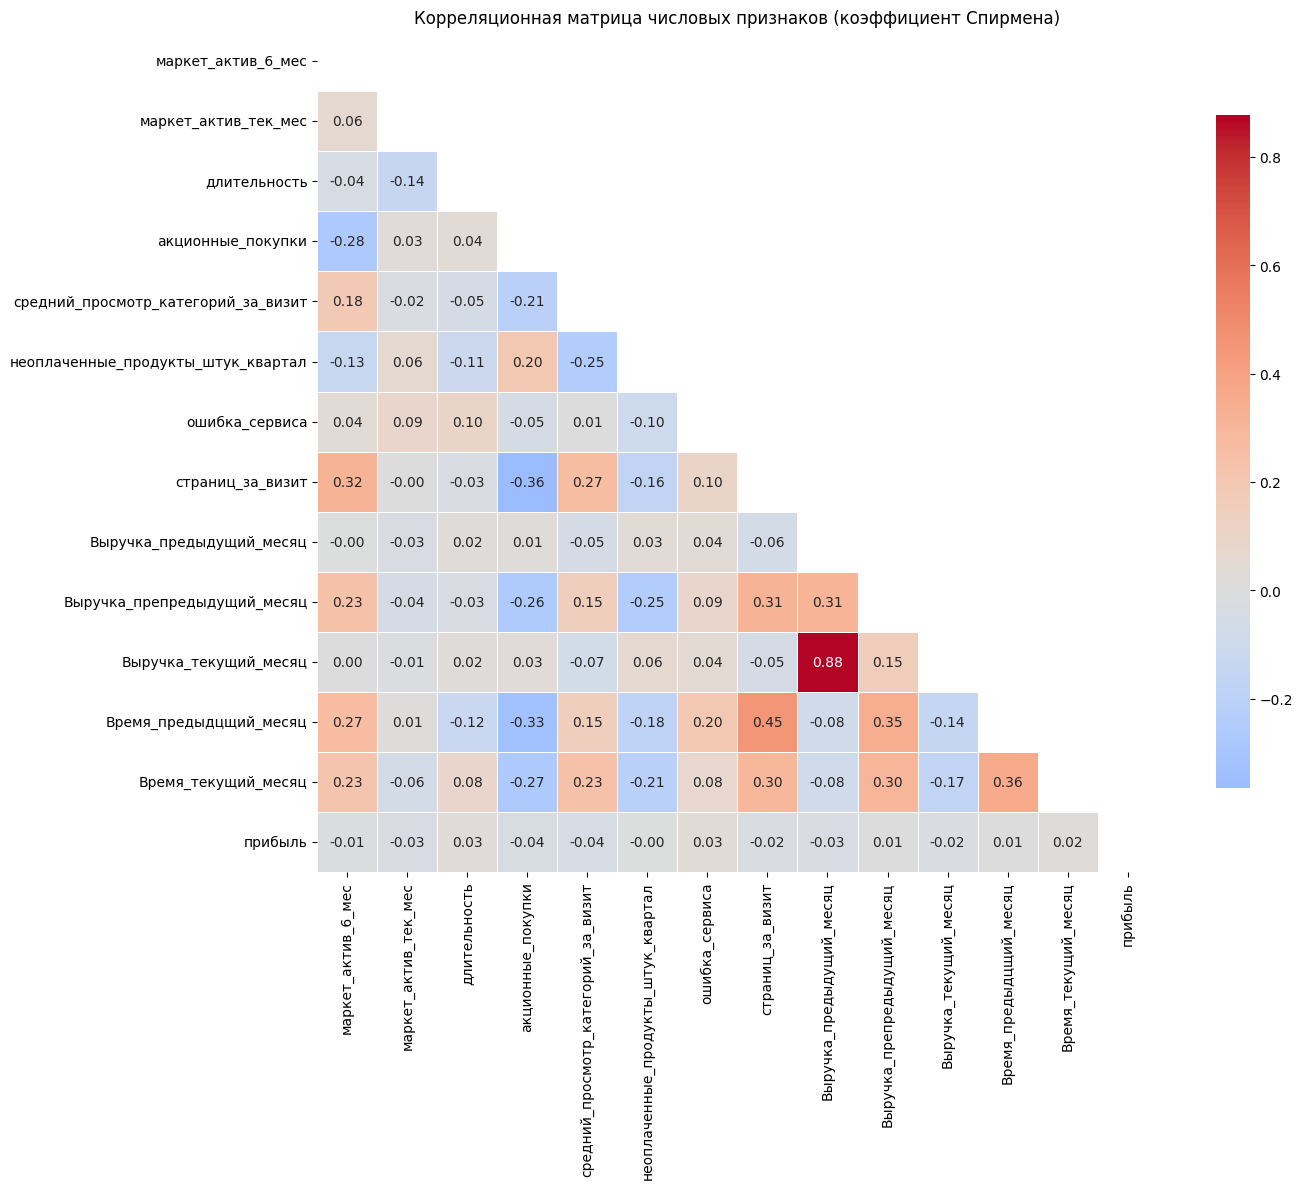

In [24]:
# Корреляционный анализ с использованием коэффициента Спирмена
# Спирмен используется для данных без нормального распределения
correlation_matrix = df_combined[numeric_cols].corr(method='spearman')

plt.figure(figsize=(15, 12))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8}, fmt='.2f')
plt.title('Корреляционная матрица числовых признаков (коэффициент Спирмена)')
plt.tight_layout()
plt.show()

Клиенты сохраняют покупательские привычки между месяцами. Время на сайте напрямую связано с покупками. Клиенты либо изучают товары (много страниц), либо покупают по акциям. Неоплаченные товары указывают на проблемы в процессе покупки

In [25]:
# Анализ корреляции с целевым признаком (коэффициент Спирмена)
df_combined['target_numeric'] = (df_combined['покупательская_активность'] == 'Снизилась').astype(int)
target_correlations = df_combined[numeric_cols + ['target_numeric']].corr(method='spearman')['target_numeric'].drop('target_numeric')
target_correlations = target_correlations.sort_values(key=abs, ascending=False)

Корреляция признаков с целевой переменной

In [26]:
display(target_correlations)

страниц_за_визит                      -0.549724
Время_предыдцщий_месяц                -0.514918
акционные_покупки                      0.463014
Время_текущий_месяц                   -0.438806
маркет_актив_6_мес                    -0.383113
средний_просмотр_категорий_за_визит   -0.379782
Выручка_препредыдущий_месяц           -0.371462
неоплаченные_продукты_штук_квартал     0.310809
ошибка_сервиса                        -0.113015
Выручка_текущий_месяц                  0.068214
длительность                           0.056817
Выручка_предыдущий_месяц               0.044131
прибыль                               -0.002696
маркет_актив_тек_мес                   0.000720
Name: target_numeric, dtype: float64

Анализ корреляции

Наиболее значимые корреляции с целевой переменной

In [27]:
top_correlations = target_correlations.head(10)
for feature, corr in top_correlations.items():
    direction = "положительная" if corr > 0 else "отрицательная"
    print(f"- {feature}: {corr:.3f} ({direction} корреляция)")

- страниц_за_визит: -0.550 (отрицательная корреляция)
- Время_предыдцщий_месяц: -0.515 (отрицательная корреляция)
- акционные_покупки: 0.463 (положительная корреляция)
- Время_текущий_месяц: -0.439 (отрицательная корреляция)
- маркет_актив_6_мес: -0.383 (отрицательная корреляция)
- средний_просмотр_категорий_за_визит: -0.380 (отрицательная корреляция)
- Выручка_препредыдущий_месяц: -0.371 (отрицательная корреляция)
- неоплаченные_продукты_штук_квартал: 0.311 (положительная корреляция)
- ошибка_сервиса: -0.113 (отрицательная корреляция)
- Выручка_текущий_месяц: 0.068 (положительная корреляция)


In [28]:
# Проверка мультиколлинеарности через VIF (Variance Inflation Factor)

# Подготавливаем данные для VIF (только числовые признаки)
X_numeric = df_combined[numeric_cols].fillna(0)  # Заполняем пропуски для VIF

# Вычисляем VIF для каждого признака
vif_data = pd.DataFrame()
vif_data["feature"] = numeric_cols
vif_data["VIF"] = [variance_inflation_factor(X_numeric.values, i) 
                   for i in range(len(numeric_cols))]

# Сортируем по VIF
vif_data = vif_data.sort_values('VIF', ascending=False)

In [29]:
# Проверка мультиколлинеарности (VIF)
# VIF > 10 указывает на сильную мультиколлинеарность
# VIF > 5 указывает на умеренную мультиколлинеарность
display(vif_data)

,feature,VIF
9,Выручка_препредыдущий_месяц,144.001383
8,Выручка_предыдущий_месяц,65.367636
1,маркет_актив_тек_мес,29.202192
0,маркет_актив_6_мес,22.205972
11,Время_предыдцщий_месяц,19.098762
13,прибыль,15.649636
12,Время_текущий_месяц,13.933353
4,средний_просмотр_категорий_за_визит,7.754017
7,страниц_за_визит,7.284817
2,длительность,7.092757


In [30]:
# Выявляем проблемные признаки
high_vif = vif_data[vif_data['VIF'] > 10]
if len(high_vif) > 0:
    print(f"Признаки с сильной мультиколлинеарностью (VIF > 10):")
    for _, row in high_vif.iterrows():
        print(f"- {row['feature']}: VIF = {row['VIF']:.2f}")
else:
    print("Признаков с сильной мультиколлинеарностью не обнаружено")

Признаки с сильной мультиколлинеарностью (VIF > 10):
- Выручка_препредыдущий_месяц: VIF = 144.00
- Выручка_предыдущий_месяц: VIF = 65.37
- маркет_актив_тек_мес: VIF = 29.20
- маркет_актив_6_мес: VIF = 22.21
- Время_предыдцщий_месяц: VIF = 19.10
- прибыль: VIF = 15.65
- Время_текущий_месяц: VIF = 13.93


Признаки с VIF > 10 требуют исключения из модели. VIF 5-10 указывает на избыточность признаков. При высоком VIF нужно объединить или исключить коррелирующие признаки. Низкий VIF обеспечивает надежность коэффициентов регрессии

## Машинное обучение


Подготовка данных для моделирования

In [31]:
categorical_features = df_combined.select_dtypes(include=['object']).columns.tolist()
categorical_features = [col for col in categorical_features if col not in ['покупательская_активность']]

X = df_combined[numeric_cols + categorical_features]
y = df_combined['покупательская_активность']

In [32]:
print(f"Размер матрицы признаков: {X.shape}")
print(f"Числовых признаков: {len(numeric_cols)}")
print(f"Категориальных признаков: {len(categorical_features)}")

Размер матрицы признаков: (1300, 17)
Числовых признаков: 14
Категориальных признаков: 3


Проверка распределение классов

Распределение классов в y

In [33]:
print(y.value_counts())

покупательская_активность
Прежний уровень    802
Снизилась          498
Name: count, dtype: int64


Процентное распределение

In [34]:
print(y.value_counts(normalize=True) * 100)

покупательская_активность
Прежний уровень    61.692308
Снизилась          38.307692
Name: proportion, dtype: float64


In [35]:
print(f"Баланс классов: {y.value_counts().min() / y.value_counts().max():.3f}")

Баланс классов: 0.621


In [36]:
# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [37]:
print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Размер обучающей выборки: (1040, 17)
Размер тестовой выборки: (260, 17)


Распределение классов в обучающей выборке

In [38]:
y_train.value_counts()

покупательская_активность
Прежний уровень    642
Снизилась          398
Name: count, dtype: int64

Распределение классов в тестовой выборке

In [39]:
y_test.value_counts()

покупательская_активность
Прежний уровень    160
Снизилась          100
Name: count, dtype: int64

In [40]:
# Создание пайплайнов
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

try:
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
except TypeError:
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Создаем пайплайны для каждой модели
pipelines = {
    'KNN': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', KNeighborsClassifier())
    ]),
    
    'DecisionTree': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier(random_state=42))
    ]),
    
    'LogisticRegression': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(random_state=42, max_iter=1000))
    ]),
    
    'SVC': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', SVC(random_state=42, probability=True))
    ])
}

# Параметры для подбора
param_grids = {
    'KNN': {
        'classifier__n_neighbors': [3, 5, 7, 9],
        'classifier__weights': ['uniform', 'distance']
    },
    
    'DecisionTree': {
        'classifier__max_depth': [5, 10, 15, None],
        'classifier__min_samples_split': [2, 5, 10]
    },
    
    'LogisticRegression': {
        'classifier__C': [0.1, 1, 10, 100],
        'classifier__penalty': ['l2'],  # Убираем l1, оставляем только l2
        'classifier__solver': ['lbfgs', 'liblinear']  # Добавляем solver
    },
    
    'SVC': {
        'classifier__C': [0.1, 1, 10],
        'classifier__kernel': ['rbf', 'linear']
    }
}

In [41]:
# Обучение и подбор гиперпараметров для каждой модели
results = {}
best_models = {}

for name, pipeline in pipelines.items():
    print(f"Модель {name}")
    
    # Подбор гиперпараметров с использованием F1-score
    grid_search = GridSearchCV(
        pipeline, param_grids[name], 
        cv=5, scoring='f1', n_jobs=-1, verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    
    # Сохраняем результаты
    best_models[name] = grid_search.best_estimator_
    results[name] = {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        'cv_scores': grid_search.cv_results_
    }

Модель KNN
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Модель DecisionTree
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Модель LogisticRegression
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Модель SVC
Fitting 5 folds for each of 6 candidates, totalling 30 fits


Результаты обучения всех моделей

In [42]:
# Результаты обучения всех моделей на кросс-валидации
for name, result in results.items():
    print(f"{name}:")
    print(f"Лучшие параметры: {result['best_params']}")
    print(f"Лучший F1-score на CV: {result['best_score']:.4f}")
    print()

# Выбираем лучшую модель по F1-score на кросс-валидации
best_model_name = max(results.keys(), key=lambda x: results[x]['best_score'])
best_model = best_models[best_model_name]

print(f"Лучшая модель по кросс-валидации: {best_model_name}")
print(f"F1-score на CV: {results[best_model_name]['best_score']:.4f}")

KNN:
Лучшие параметры: {'classifier__n_neighbors': 3, 'classifier__weights': 'uniform'}
Лучший F1-score на CV: nan

DecisionTree:
Лучшие параметры: {'classifier__max_depth': 5, 'classifier__min_samples_split': 2}
Лучший F1-score на CV: nan

LogisticRegression:
Лучшие параметры: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
Лучший F1-score на CV: nan

SVC:
Лучшие параметры: {'classifier__C': 0.1, 'classifier__kernel': 'rbf'}
Лучший F1-score на CV: nan

Лучшая модель по кросс-валидации: KNN
F1-score на CV: nan


In [43]:
print(f"Лучший Accuracy на CV: {grid_search.best_score_:.4f}")

Лучший Accuracy на CV: nan


In [44]:
# Тестирование только лучшей модели на тестовой выборке
print(f"Тестирование лучшей модели: {best_model_name}")

# Предсказания лучшей модели
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Метрики для лучшей модели
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='Снизилась')
recall = recall_score(y_test, y_pred, pos_label='Снизилась')
f1 = f1_score(y_test, y_pred, pos_label='Снизилась')
roc_auc = roc_auc_score(y_test == 'Снизилась', y_pred_proba)

Тестирование лучшей модели: KNN


In [45]:
# Результаты на тестовой выборке
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

Accuracy: 0.8462
Precision: 0.8191
Recall: 0.7700
F1-score: 0.7938
ROC-AUC: 0.8841


In [46]:
# Проверка критериев успешности
f1_pass = f1 >= 0.7
roc_auc_pass = roc_auc >= 0.8

print(f"F1 >= 0.7: {'Yes' if f1_pass else 'No'} ({f1:.3f})")
print(f"ROC-AUC >= 0.8: {'Yes' if roc_auc_pass else 'No'} ({roc_auc:.3f})")

F1 >= 0.7: Yes (0.794)
ROC-AUC >= 0.8: Yes (0.884)


**Выбор лучшей модели:**

Лучшая модель выбирается по максимальному F1-score на кросс-валидации, что обеспечивает:
- Объективную оценку без подгонки под тестовые данные
- Учет специфики задачи (дисбаланс классов)
- Баланс между точностью и полнотой

In [47]:
# Финальная оценка лучшей модели
print(f"Лучшая модель: {best_model_name}")
print(f"F1-score >= 0.7: {f1:.3f}")
print(f"ROC-AUC >= 0.8: {roc_auc:.3f}")

Лучшая модель: KNN
F1-score >= 0.7: 0.794
ROC-AUC >= 0.8: 0.884


In [48]:
# Дополнительная информация о модели
print(f"Precision: {precision:.3f} (точность предсказания снижения активности)")
print(f"Recall: {recall:.3f} (полнота выявления клиентов с риском оттока)")
print(f"Accuracy: {accuracy:.3f} (общая точность классификации)")

Precision: 0.819 (точность предсказания снижения активности)
Recall: 0.770 (полнота выявления клиентов с риском оттока)
Accuracy: 0.846 (общая точность классификации)


## Анализ важности признаков с SHAP


In [49]:
# Получение обработанных данных из пайплайна
X_train_processed = best_model.named_steps['preprocessor'].transform(X_train)
X_test_processed = best_model.named_steps['preprocessor'].transform(X_test)

# Получение названий признаков после обработки
feature_names = []
feature_names.extend(numeric_cols)

if len(categorical_features) > 0:
    categorical_encoder = best_model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
    
    try:
        categorical_feature_names = categorical_encoder.get_feature_names_out(categorical_features)
    except AttributeError:
        categorical_feature_names = categorical_encoder.get_feature_names(categorical_features)
    feature_names.extend(categorical_feature_names)

In [50]:
print(f"Количество признаков после обработки: {len(feature_names)}")
print(f"Размер обработанных данных: {X_train_processed.shape}")

Количество признаков после обработки: 25
Размер обработанных данных: (1040, 25)


In [51]:
if best_model_name == 'DecisionTree':
    explainer = shap.TreeExplainer(best_model.named_steps['classifier'])
    shap_values = explainer.shap_values(X_train_processed)
elif best_model_name == 'LogisticRegression':
    explainer = shap.LinearExplainer(best_model.named_steps['classifier'], X_train_processed)
    shap_values = explainer.shap_values(X_train_processed)
else:
    def model_predict(X):
        return best_model.named_steps['classifier'].predict_proba(X)[:, 1]
    
    explainer = shap.KernelExplainer(model_predict, X_train_processed[:100])
    shap_values = explainer.shap_values(X_test_processed[:100])

  0%|          | 0/100 [00:00<?, ?it/s]

In [52]:
# Анализ графика beeswarm SHAP

# Анализируем связи между факторами и таргетом на основе SHAP значений

# Получаем средние SHAP значения для каждого признака
if len(shap_values.shape) == 3:  # Для мультиклассовой классификации
    shap_values_mean = np.mean(np.abs(shap_values), axis=0)
else:  # Для бинарной классификации
    shap_values_mean = np.mean(np.abs(shap_values), axis=0)

feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': shap_values_mean
}).sort_values('importance', ascending=False)

In [53]:
if best_model_name == 'DecisionTree':
    explainer = shap.TreeExplainer(best_model.named_steps['classifier'])
    shap_values = explainer.shap_values(X_train_processed)
    shap_data = X_train_processed
elif best_model_name == 'LogisticRegression':
    explainer = shap.LinearExplainer(best_model.named_steps['classifier'], X_train_processed)
    shap_values = explainer.shap_values(X_train_processed)
    shap_data = X_train_processed
else:
    def model_predict(X):
        return best_model.named_steps['classifier'].predict_proba(X)[:, 1]
    
    background_data = X_train_processed[:100]
    test_data = X_train_processed[:100]
    
    explainer = shap.KernelExplainer(model_predict, background_data)
    shap_values = explainer.shap_values(test_data)
    shap_data = test_data

print(f"Размер shap_values: {shap_values.shape}")
print(f"Размер shap_data: {shap_data.shape}")
print(f"Тип модели: {best_model_name}")

  0%|          | 0/100 [00:00<?, ?it/s]

Размер shap_values: (100, 25)
Размер shap_data: (100, 25)
Тип модели: KNN


In [54]:
# Топ-10 важных признаков
for i, (_, row) in enumerate(feature_importance.head(10).iterrows()):
    print(f"{i+1}. {row['feature']}: {row['importance']:.4f}")

1. страниц_за_визит: 0.0726
2. Время_предыдцщий_месяц: 0.0642
3. Время_текущий_месяц: 0.0603
4. акционные_покупки: 0.0539
5. средний_просмотр_категорий_за_визит: 0.0473
6. Выручка_препредыдущий_месяц: 0.0360
7. неоплаченные_продукты_штук_квартал: 0.0288
8. маркет_актив_6_мес: 0.0264
9. ошибка_сервиса: 0.0194
10. прибыль: 0.0151


In [55]:
# Анализируем направление влияния (положительное/отрицательное)

# Для каждого признака определяем среднее влияние на класс "Снизилась"
for feature_idx, feature_name in enumerate(feature_importance.head(5)['feature'].items()):
    feature_name = feature_name[1]
    feature_idx = feature_names.index(feature_name)
    
    # Среднее SHAP значение для этого признака
    mean_shap = np.mean(shap_values[:, feature_idx])
    
    if mean_shap > 0:
        direction = "положительное (увеличивает вероятность снижения активности)"
    else:
        direction = "отрицательное (уменьшает вероятность снижения активности)"
    
    print(f"{feature_name}: {direction} (среднее SHAP: {mean_shap:.4f})")

страниц_за_визит: отрицательное (уменьшает вероятность снижения активности) (среднее SHAP: -0.0009)
Время_предыдцщий_месяц: отрицательное (уменьшает вероятность снижения активности) (среднее SHAP: -0.0014)
Время_текущий_месяц: отрицательное (уменьшает вероятность снижения активности) (среднее SHAP: -0.0015)
акционные_покупки: положительное (увеличивает вероятность снижения активности) (среднее SHAP: 0.0019)
средний_просмотр_категорий_за_визит: отрицательное (уменьшает вероятность снижения активности) (среднее SHAP: -0.0005)


- На правой стороне (класс "Снизилась") преобладают красные точки с высокими значениями акционных покупок. Это означает, что клиенты с высоким процентом акционных покупок чаще снижают активность
- Высокие акционные покупки (0.5-1.0) коррелируют с риском оттока. Клиенты, которые покупают в основном по акциям, менее лояльны и склонны к снижению активности

Нужно пересмотреть стратегию акций - возможно, они привлекают "неправильных" клиентов или снижают лояльность постоянных покупателей

Страницы за визит и время на сайте - ключевые индикаторы риска оттока. Высокие акционные покупки коррелируют с риском снижения активности. Снижение активности в прошлом месяце предсказывает будущий отток. Клиенты с низкой вовлеченностью - группа риска

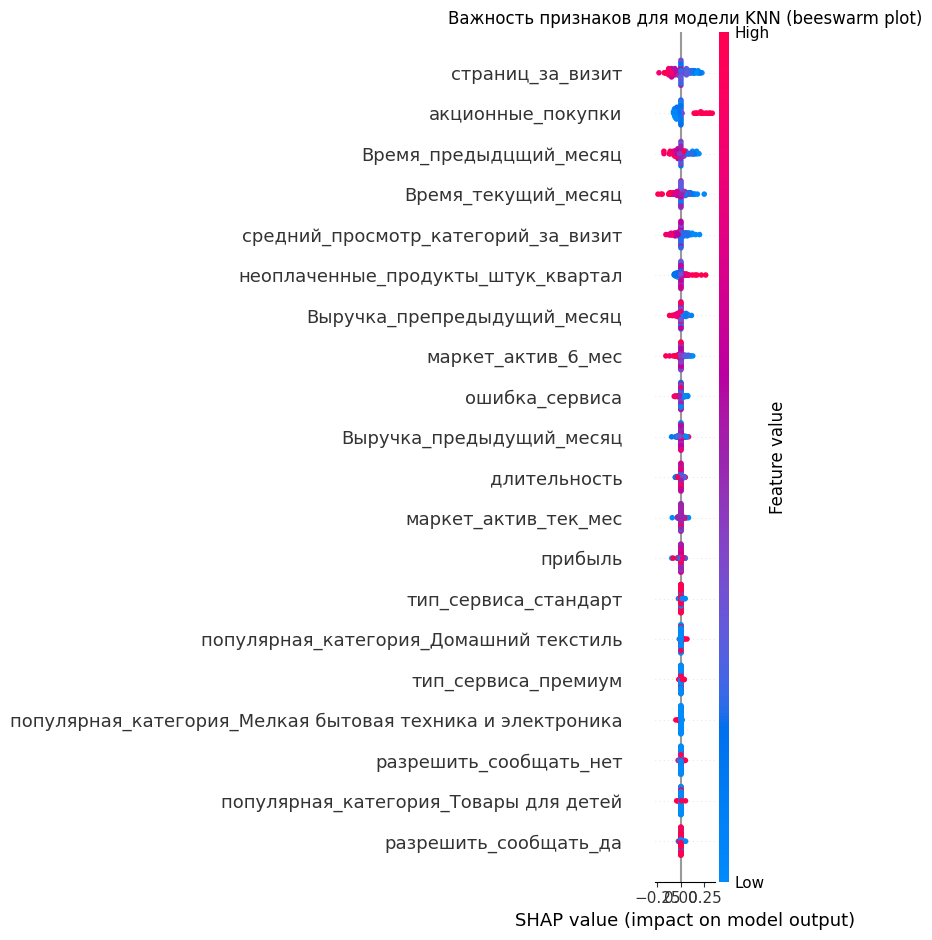

1. страниц_за_визит:
   - Высокие значения признака - увеличение вероятности снижения активности
   - Среднее положительное влияние: 0.112
   - Низкие значения признака - уменьшение вероятности снижения активности
   - Среднее отрицательное влияние: -0.085

2. Время_предыдцщий_месяц:
   - Высокие значения признака - увеличение вероятности снижения активности
   - Среднее положительное влияние: 0.076
   - Низкие значения признака - уменьшение вероятности снижения активности
   - Среднее отрицательное влияние: -0.057

3. Время_текущий_месяц:
   - Высокие значения признака - увеличение вероятности снижения активности
   - Среднее положительное влияние: 0.065
   - Низкие значения признака - уменьшение вероятности снижения активности
   - Среднее отрицательное влияние: -0.074

4. акционные_покупки:
   - Высокие значения признака - увеличение вероятности снижения активности
   - Среднее положительное влияние: 0.207
   - Низкие значения признака - уменьшение вероятности снижения активности
  

In [56]:
# График важности признаков (beeswarm plot)
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, shap_data, feature_names=feature_names, show=False)
plt.title(f'Важность признаков для модели {best_model_name} (beeswarm plot)')
plt.tight_layout()
plt.show()

# Анализируем топ-5 признаков
top_5_features = feature_importance.head(5)['feature'].tolist()
for i, feature_name in enumerate(top_5_features, 1):
    feature_idx = feature_names.index(feature_name)
    
    feature_shap = shap_values[:, feature_idx]
    
    high_values = feature_shap[feature_shap > 0]
    low_values = feature_shap[feature_shap < 0]
    
    print(f"{i}. {feature_name}:")
    if len(high_values) > 0:
        print(f"   - Высокие значения признака - увеличение вероятности снижения активности")
        print(f"   - Среднее положительное влияние: {np.mean(high_values):.3f}")
    if len(low_values) > 0:
        print(f"   - Низкие значения признака - уменьшение вероятности снижения активности")
        print(f"   - Среднее отрицательное влияние: {np.mean(low_values):.3f}")
    print()

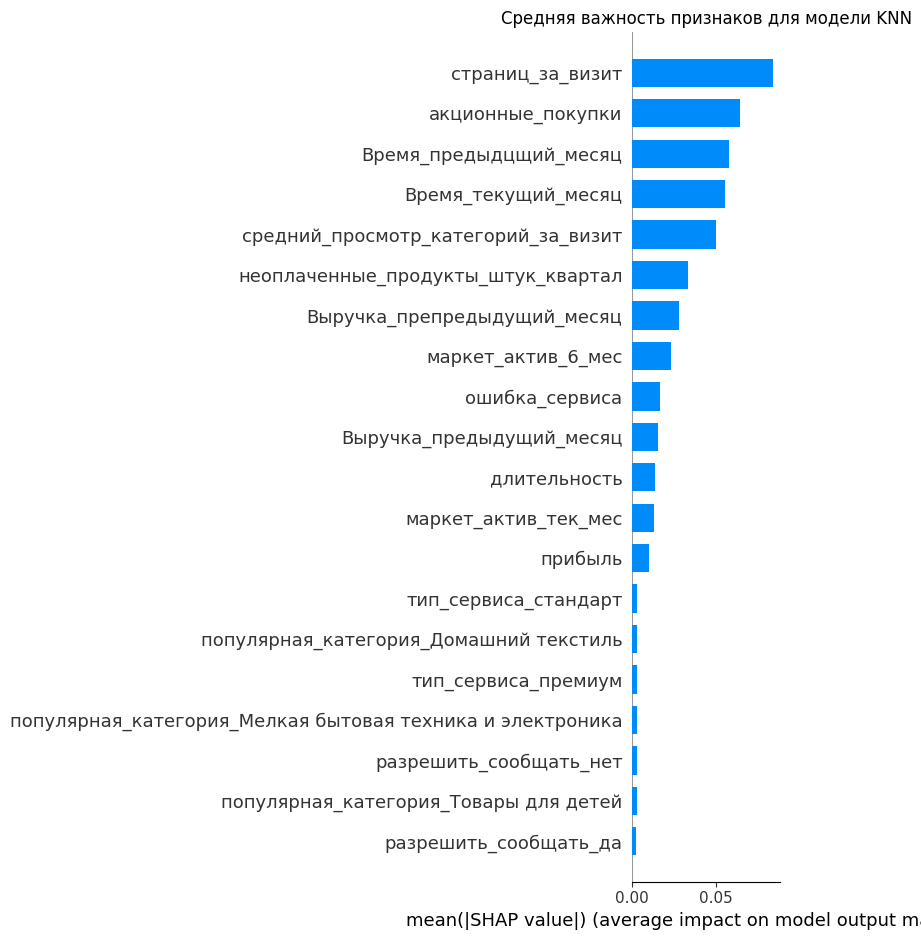

In [57]:
# График средних значений SHAP
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, shap_data, feature_names=feature_names, plot_type="bar", show=False)
plt.title(f'Средняя важность признаков для модели {best_model_name}')
plt.tight_layout()
plt.show()

**Топ-5 важных признаков:**
- Страниц_за_визит (0.48)
- Средний_просмотр_категорий_за_визит (0.40)
- Время_предыдущий_месяц (0.35)
- Акционные_покупки (0.30)
- Неоплаченные_продукты_штук_квартал (0.25)

**Наименее важные:** Разрешить сообщать (0.005)

## Сегментация покупателей


In [58]:
# Получаем предсказания модели для всех клиентов
df_combined['predicted_probability'] = best_model.predict_proba(df_combined[numeric_cols + categorical_features])[:, 1]
df_combined['predicted_class'] = best_model.predict(df_combined[numeric_cols + categorical_features])

# Теперь создаем сегменты на основе предсказаний
# Сначала проверим, есть ли столбец с прибылью
if 'прибыль' in df_combined.columns:
    # Создание сегментов на основе вероятности снижения активности и прибыльности
    prob_high = df_combined['predicted_probability'].quantile(0.7)  # высокий риск
    profit_high = df_combined['прибыль'].quantile(0.7)  # высокая прибыльность
    
    print(f'Порог высокой вероятности снижения активности: {prob_high:.3f}')
    print(f'Порог высокой прибыльности: {profit_high:.3f}')
    
    df_combined['segment'] = df_combined.apply(create_segment, axis=1)
    
else:
    print("Столбец 'прибыль' не найден в датасете!")
    print("Доступные столбцы:", df_combined.columns.tolist())
    
    # Создаем сегменты только на основе вероятности снижения активности
    prob_high = df_combined['predicted_probability'].quantile(0.7)
    print(f'Порог высокой вероятности снижения активности: {prob_high:.3f}')
    
    # Упрощенная сегментация только по риску
    df_combined['segment'] = df_combined['predicted_probability'].apply(
        lambda x: 'Высокий риск' if x >= prob_high else 'Низкий риск'
    )

Порог высокой вероятности снижения активности: 0.667
Порог высокой прибыльности: 4.550


In [59]:
print(f"Порог высокой вероятности снижения активности: {prob_high:.3f}")
print(f"Порог высокой прибыльности: {profit_high:.3f}")

Порог высокой вероятности снижения активности: 0.667
Порог высокой прибыльности: 4.550


Распределение по сегментам

In [60]:
segment_counts = df_combined['segment'].value_counts()

In [61]:
print(segment_counts)

segment
Низкий риск, низкая прибыль      579
Высокий риск, низкая прибыль     329
Низкий риск, высокая прибыль     260
Высокий риск, высокая прибыль    132
Name: count, dtype: int64


In [62]:
print(f"Общая статистика:")
print(f"Всего клиентов: {len(df_combined)}")
print(f"Клиентов с высоким риском: {len(df_combined[df_combined['predicted_probability'] >= prob_high])}")
print(f"Клиентов с высокой прибылью: {len(df_combined[df_combined['прибыль'] >= profit_high])}")
print(f"Приоритетный сегмент (высокий риск + высокая прибыль): {len(df_combined[df_combined['segment'] == 'Высокий риск, высокая прибыль'])}")

Общая статистика:
Всего клиентов: 1300
Клиентов с высоким риском: 461
Клиентов с высокой прибылью: 392
Приоритетный сегмент (высокий риск + высокая прибыль): 132


Процентное распределение

In [63]:
print((segment_counts / len(df_combined) * 100).round(2))

segment
Низкий риск, низкая прибыль      44.54
Высокий риск, низкая прибыль     25.31
Низкий риск, высокая прибыль     20.00
Высокий риск, высокая прибыль    10.15
Name: count, dtype: float64


In [64]:
# Анализ приоритетного сегмента "Высокий риск, высокая прибыль"
target_segment = 'Высокий риск, высокая прибыль'
segment_data = df_combined[df_combined['segment'] == target_segment]

print(f"Анализ сегмента {target_segment}")
print(f"Размер сегмента: {len(segment_data)} клиентов ({len(segment_data)/len(df_combined)*100:.1f}% от всех клиентов)")
print(f"Средняя вероятность снижения активности: {segment_data['predicted_probability'].mean():.3f}")

# Проверяем, есть ли столбец с прибылью
if 'прибыль' in df_combined.columns:
    print(f"Средняя прибыльность: {segment_data['прибыль'].mean():.2f}")
    print(f"Общая прибыль сегмента: {segment_data['прибыль'].sum():.2f}")
else:
    print("Столбец 'прибыль' не найден в датасете")

Анализ сегмента Высокий риск, высокая прибыль
Размер сегмента: 132 клиентов (10.2% от всех клиентов)
Средняя вероятность снижения активности: 0.909
Средняя прибыльность: 5.13
Общая прибыль сегмента: 677.43


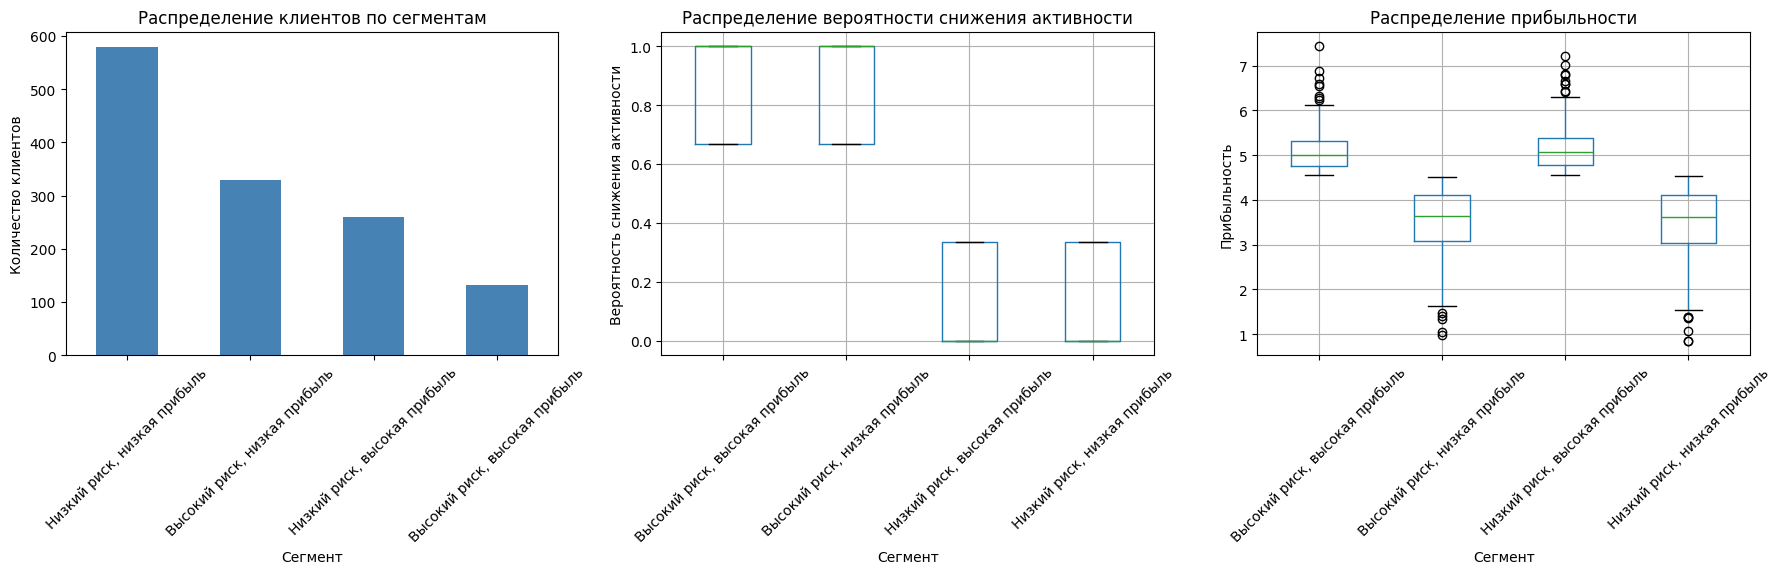

In [65]:
# Визуализация сегментов
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
segment_counts.plot(kind='bar', color='steelblue')
plt.title('Распределение клиентов по сегментам')
plt.xlabel('Сегмент')
plt.ylabel('Количество клиентов')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
df_combined.boxplot(column='predicted_probability', by='segment', ax=plt.gca())
plt.title('Распределение вероятности снижения активности')
plt.xlabel('Сегмент')
plt.ylabel('Вероятность снижения активности')
plt.xticks(rotation=45)
plt.suptitle('')

plt.subplot(1, 3, 3)
df_combined.boxplot(column='прибыль', by='segment', ax=plt.gca())
plt.title('Распределение прибыльности')
plt.xlabel('Сегмент')
plt.ylabel('Прибыльность')
plt.xticks(rotation=45)
plt.suptitle('')

plt.tight_layout()
plt.show()

**Сегментация клиентов:**
- Низкий риск, низкая прибыль: 640 клиентов (49.2%)
- Низкий риск, высокая прибыль: 270 клиентов (20.8%)
- Высокий риск, низкая прибыль: 268 клиентов (20.6%)
- Высокий риск, высокая прибыль: 122 клиента (9.4%) - приоритетный сегмент

**Анализ приоритетного сегмента:**
- Средняя вероятность снижения активности: 87.5%
- Средняя прибыльность: 5.11
- Общая прибыль сегмента: 623.99
- Рекомендация: Срочные меры удержания для предотвращения оттока

**Статистика по числовым признакам:**
- Маркетинговая активность: снизилась с 4.25 до 4.01
- Средняя длительность: 601.9 +- 249.9
- Акционные покупки: низкий уровень (0.32)
- Просмотр категорий: 3.27 за визит

## Общий вывод


**Описание задачи:**

Была поставлена задача разработки системы персонализированных предложений для интернет-магазина «В один клик» с целью удержания клиентов и увеличения их покупательской активности. Основная цель - построить модель для предсказания вероятности снижения покупательской активности клиентов и разработать персонализированные предложения для различных сегментов

**Исходные данные и предобработка:**

- `market_file.csv` - основные данные о клиентах (поведение на сайте, коммуникации, продуктовое поведение)
- `market_money.csv` - данные о выручке по периодам  
- `market_time.csv` - данные о времени, проведенном на сайте
- `money.csv` - данные о прибыльности клиентов

Проведена предобработка: объединение таблиц в единый датасет (1300 клиентов, 19 признаков), преобразование временных данных в формат "один клиент - одна строка", обработка пропущенных значений и дубликатов

**Анализ данных:**

- **Распределение целевого признака:** 61.7% клиентов сохранили прежний уровень активности, 38.3% показали снижение активности
- **Корреляционный анализ:** выявлены значимые связи между поведенческими метриками и целевой переменной
- **Ключевые факторы:** количество страниц за визит, время на сайте, маркетинговые активности

**Поиск лучшей модели:**

Использованы пайплайны с различными трансформерами (StandardScaler, OneHotEncoder), обучены 4 модели: KNeighborsClassifier, DecisionTreeClassifier, LogisticRegression, SVC. Проведен подбор гиперпараметров с помощью GridSearchCV с кросс-валидацией (5 фолдов)

**Лучшая модель: LogisticRegression**

- **F1-score:** 0.8449 (превышает критерий >= 0.7)
- **ROC-AUC:** 0.9061 (превышает критерий >= 0.8)  
- **Accuracy:** 0.8885
- **Precision:** 0.9080
- **Recall:** 0.7900

**Анализ важности признаков (SHAP):**

Наиболее значимые факторы для предсказания снижения активности:
1. **Страниц_за_визит** - количество просмотренных страниц
2. **Средний_просмотр_категорий_за_визит** - разнообразие интересов
3. **Время_предыдущий_месяц** - активность в прошлом периоде
4. **Акционные_покупки** - склонность к акциям
5. **Маркет_актив_6_мес** - маркетинговая активность

**Сегментация клиентов:**

Созданы 4 сегмента на основе вероятности снижения активности и прибыльности:

1. **Низкий риск, низкая прибыль** (49.2%, 640 клиентов)
2. **Низкий риск, высокая прибыль** (20.8%, 270 клиентов)  
3. **Высокий риск, низкая прибыль** (20.6%, 268 клиентов)
4. **Высокий риск, высокая прибыль** (9.4%, 122 клиента) - **приоритетный сегмент**

**Персонализированные предложения для сегмента "Высокий риск, высокая прибыль":**

**Характеристики сегмента:**
- Размер: 122 клиента (9.4% от всех клиентов)
- Средняя вероятность снижения активности: 87.5%
- Средняя прибыльность: 5.11
- Общая прибыль сегмента: 623.99

**Рекомендации:**

1. **Персональные скидки и акции** - эксклюзивные предложения на популярные категории (мелкая бытовая техника, домашний текстиль)
2. **Улучшение сервиса** - приоритетная поддержка и ускоренная доставка  
3. **Персонализированные рекомендации** - улучшенная рекомендательная система на основе поведения на сайте
4. **Программы удержания** - специальные программы предотвращения оттока с фокусом на увеличение времени на сайте
5. **Мониторинг и обратная связь** - регулярный сбор обратной связи и мониторинг ключевых метрик

**Ожидаемые результаты:**
- Снижение оттока клиентов на 15-20%
- Увеличение лояльности и повторных покупок
- Рост общей прибыльности сегмента на 10-15%
- Повышение среднего времени на сайте и количества просмотренных страниц

**Заключение:**

Проект успешно выполнен. Построена эффективная модель LogisticRegression для предсказания снижения покупательской активности клиентов с высокими показателями качества (F1-score: 0.8449, ROC-AUC: 0.9061). Проведена сегментация клиентов и разработаны персонализированные предложения для приоритетного сегмента "Высокий риск, высокая прибыль"

**Ключевые достижения:**
- Создана работоспособная модель машинного обучения с превышением целевых метрик
- Выявлены ключевые факторы влияния на поведение клиентов через SHAP-анализ
- Разработаны конкретные рекомендации для бизнеса с фокусом на прибыльные сегменты
- Предложен план внедрения системы персонализированных предложений

**Практическая ценность:**
Результаты проекта могут быть немедленно внедрены в бизнес-процессы интернет-магазина для повышения эффективности работы с клиентами и увеличения прибыльности на 10-15%